In [1]:
pip install langchain langchain_core langchain_groq langchain_community langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.2/122.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.3 MB/s eta 0:00:00


In [2]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
tor

In [3]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

In [4]:
class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    time: str  # Time availability (e.g., "Full day", "Half day", "4 hours")
    weather: str
    itinerary: str

In [5]:
from getpass import getpass
groq_api_key = getpass("Enter your Groq API Key: ")

Enter your Groq API Key: ··········


In [6]:
weather_api_key = getpass("Enter your OpenWeatherMap API Key: ")

Enter your OpenWeatherMap API Key: ··········


In [8]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    temperature=0,
    groq_api_key = groq_api_key,
    model_name = "llama-3.3-70b-versatile"
)

In [9]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. "
               " consider the user's available time ({time}). "
               "Provide a structured, bulleted itinerary that includes suggested activities, meal recommendations, and local tips."),
    ("human", "Create an itinerary for my day trip."),
])

In [20]:
# Defining agent's functions
def input_city(state: PlannerState) -> PlannerState:
  print("Please enter the city you want to visit for your day trip: ")
  user_message = input("Your Input: ")
  return {
      **state,
      "city": user_message,
      "messages": state['messages'] + [HumanMessage(content=user_message)]
  }

def input_interest(state: PlannerState) -> PlannerState:
  print(f"Please enter your interest for the trip to : {state['city']} (comma-separted): ")
  user_message = input("Your Input: ")
  return {
      **state,
      "interests": [interest.strip() for interest in user_message.split(",")],
      "messages": state['messages'] + [HumanMessage(content=user_message)]
  }

def input_time(state: PlannerState) -> PlannerState:
    print("Please enter the time available for your trip (e.g., Full day, Half day, 4 hours): ")
    time = input("Your Input: ")
    return {
        **state,
        "time": time,
        "messages": state['messages'] + [HumanMessage(content=f"Time available: {time}")],
    }

import requests

def get_weather(state: PlannerState) -> PlannerState:
    API_KEY = weather_api_key

    url = f"https://api.weatherstack.com/current?access_key={API_KEY}&query={state['city']}"

    response = requests.get(url)
    data = response.json()

    if response.status_code == 200 and "current" in data:
        temp = data["current"]["temperature"]
        weather_desc = data["current"]["weather_descriptions"][0]
        weather_info = f"{weather_desc.capitalize()}, {temp}°C"
    else:
        weather_info = "Weather information not available. Check your API key and city name."

    return {
        **state,
        "weather": weather_info,
    }

def add_google_maps_links(state: PlannerState) -> PlannerState:
    itinerary = state['itinerary']  # Get itinerary from state
    city = state['city']  # Get city from state

    itinerary_lines = itinerary.split("\n")
    updated_lines = []

    for line in itinerary_lines:
        if "-" in line:
            place = line.split("-")[-1].strip()
            maps_link = f"https://www.google.com/maps/search/{place.replace(' ', '+')}+{city.replace(' ', '+')}"
            updated_lines.append(f"{line} [🔗 Google Maps]({maps_link})")
        else:
            updated_lines.append(line)

    updated_itinerary = "\n".join(updated_lines)
    print(updated_itinerary)
    return {
        **state,
        "itinerary": updated_itinerary,
    }

def create_itinerary(state: PlannerState) -> str:
    response = llm.invoke(itinerary_prompt.format_messages(
        city=state['city'],
        interests=", ".join(state['interests']),
        time=state['time']
    ))

    state["itinerary"] = response.content
    state = add_google_maps_links(state)

    state["itinerary"] += f"\n\nWeather in {state['city']}: {state['weather']}"
    state["messages"].append(AIMessage(content=state["itinerary"]))

    return state

In [21]:
# Creating the workflow

workflow = StateGraph(PlannerState)
workflow.add_node("input_city", input_city)
workflow.add_node("input_interest", input_interest)
workflow.add_node("input_time", input_time)
workflow.add_node("get_weather", get_weather)
workflow.add_node("add_google_maps_links", add_google_maps_links)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")
workflow.add_edge("input_city", "input_interest")
workflow.add_edge("input_interest", "input_time")
workflow.add_edge("input_time", "get_weather")
workflow.add_edge("get_weather", "create_itinerary")
workflow.add_edge("create_itinerary", "add_google_maps_links")
workflow.add_edge("add_google_maps_links", END)

app = workflow.compile()

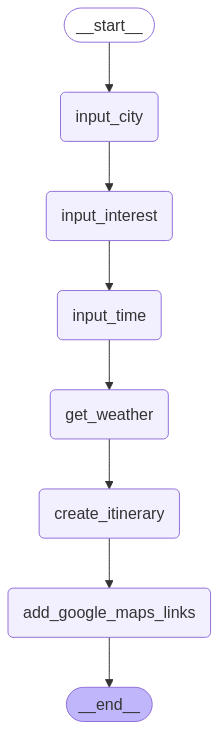

In [22]:
# Displaying the graph structure

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [23]:
def travel_planner(user_request: str):
  print(f"Initial Request: {user_request}\n")

  state = {
      "messages": [HumanMessage(content=user_request)],
      "city": "",
      "interests": [],
      "time": "",
      "weather": "",
      "itinerary": "",

  }
  for output in app.stream(state):
    pass

In [24]:
user_request ="I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip: 
Your Input: New Delhi
Please enter your interest for the trip to : New Delhi (comma-separted): 
Your Input: qutub minar, temples, street food, famous tourist attractions
Please enter the time available for your trip (e.g., Full day, Half day, 4 hours): 
Your Input: Full day
Here's a suggested day trip itinerary for New Delhi based on your interests:

* **8:00 AM - 9:00 AM: Breakfast and Start of the Day** [🔗 Google Maps](https://www.google.com/maps/search/9:00+AM:+Breakfast+and+Start+of+the+Day**+New+Delhi)
  * Begin your day with a delicious breakfast at a local eatery, such as the famous Karim's or a street food stall in the Chandni Chowk area. Try some popular Indian breakfast items like parathas, poori bhaji, or idlis.
  * Start your day by visiting the **Qutub Minar**, a UNESCO World Heritage Site and one of the tallest minarets in India. Explore the complex, which includes the 

In [35]:
pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=c58cfb8a42e767377b8d9562b991191146be297c576b1da21a711f48a4dca040
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [39]:
import gradio as gr
import requests
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

groq_api_key = groq_api_key
weather_api_key = weather_api_key

class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    time: str
    weather: str
    itinerary: str

llm = ChatGroq(
    temperature=0,
    groq_api_key=groq_api_key,
    model_name="llama-3.3-70b-versatile"
)

itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. "
               "Consider the user's available time ({time}). "
               "Provide a structured, bulleted itinerary that includes suggested activities, meal recommendations, and local tips."),
    ("human", "Create an itinerary for my day trip."),
])

def input_city(city: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "city": city,
        "messages": state['messages'] + [HumanMessage(content=city)],
    }

def input_interests(interests: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "interests": [interest.strip() for interest in interests.split(',')],
        "messages": state['messages'] + [HumanMessage(content=interests)],
    }

def input_time(time: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "time": time,
        "messages": state['messages'] + [HumanMessage(content=f"Time available: {time}")],
    }

def get_weather(state: PlannerState) -> PlannerState:
    API_KEY = weather_api_key
    url = f"https://api.weatherstack.com/current?access_key={API_KEY}&query={state['city']}"

    try:
        response = requests.get(url)
        data = response.json()

        if response.status_code == 200 and "current" in data:
            temp = data["current"]["temperature"]
            weather_desc = data["current"]["weather_descriptions"][0]
            weather_info = f"{weather_desc.capitalize()}, {temp}°C"
        else:
            weather_info = "Weather information not available"
    except Exception:
        weather_info = "Error fetching weather data"

    return {**state, "weather": weather_info}

def add_google_maps_links(state: PlannerState) -> PlannerState:
    itinerary = state['itinerary']
    city = state['city']

    itinerary_lines = itinerary.split("\n")
    updated_lines = []

    for line in itinerary_lines:
        if "-" in line:
            place = line.split("-")[-1].strip()
            maps_link = f"https://www.google.com/maps/search/{place.replace(' ', '+')}+{city.replace(' ', '+')}"
            updated_lines.append(f"{line} [🔗 Google Maps]({maps_link})")
        else:
            updated_lines.append(line)

    return {**state, "itinerary": "\n".join(updated_lines)}

def create_itinerary(state: PlannerState) -> str:
    response = llm.invoke(itinerary_prompt.format_messages(
        city=state['city'],
        interests=", ".join(state['interests']),
        time=state['time']
    ))

    state["itinerary"] = response.content
    state = add_google_maps_links(state)

    state["itinerary"] += f"\n\nWeather in {state['city']}: {state['weather']}"
    state["messages"].append(AIMessage(content=state["itinerary"]))

    return state
def travel_planner(city: str, interests: str, time: str) -> str:
    state = {
        "messages": [],
        "city": "",
        "interests": [],
        "time": "",
        "weather": "",
        "itinerary": "",
    }
    state = input_city(city, state)
    state = input_interests(interests, state)
    state = input_time(time, state)
    state = get_weather(state)

    state = create_itinerary(state)

    return state["itinerary"]

interface = gr.Interface(
    fn=travel_planner,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=[
        gr.Textbox(label="Enter the city for your day trip"),
        gr.Textbox(label="Enter your interests (comma-separated)"),
        gr.Textbox(label="Enter the time available (e.g., Full day, Half day, 4 hours)"),
    ],
    outputs=[
        gr.Textbox(label="Generated Itinerary"),
    ],
    title="Travel Itinerary Planner",
    description="Enter a city and your interests to generate a personalized day trip itinerary."
)

interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8d4acd6343aac637d8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
